# Random Forest Classification @ LCZ42

In [1]:
# Import required packages

import h5py
import numpy as np
import glob
# import sen1_cnntrain_uil as sen1cnn
import scipy.io
# from osgeo import gdal

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import pickle
import os

import seaborn


In [6]:
def predict_classes(x):
#generate class prediction from the input samples
    y=x.argmax(axis=1)+1
    return y

'''
RF parameters
'''

# Number of trees in random forest
n_estimators = [100,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [4,8,16,32]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
nb_iter = 5
nb_cv = 3


In [3]:

'''
PARAMETERS
'''
# Read in pseudo training data & assign features & labels
data_train = h5py.File('D:/Data/LCZ42/pseudo_training.h5', 'r')
x_tra = np.array(data_train['sen2'])
y_tra = np.array(data_train['label'])

# Read in pseudo testing data & assign features & labels
data_test = h5py.File('D:/Data/LCZ42/pseudo_testing.h5', 'r')
x_test = np.array(data_test['sen2'])
y_test = np.array(data_test['label'])

'''
# Step 2: feature organization for random forest: max, min, mean, std
'''

nb,rw,cl,bd = x_tra.shape
x_tra = np.reshape(x_tra,[nb,rw*cl,bd])
x_tra = np.concatenate([np.mean(x_tra,axis=1),
                        np.std(x_tra,axis=1),
                        np.min(x_tra,axis=1),
                        np.max(x_tra,axis=1)], axis=1)
y_tra = predict_classes(y_tra)

nb,rw,cl,bd = x_test.shape
x_test = np.reshape(x_test,[nb,rw*cl,bd])
x_test = np.concatenate([np.mean(x_test,axis=1),
                         np.std(x_test,axis=1),
                         np.min(x_test,axis=1),
                         np.max(x_test,axis=1)], axis=1)
y_test = predict_classes(y_test)


In [7]:
'''
# Step 3: classification using random forest, hyperparameter random search
'''
# training
rf = RandomForestClassifier()
rf_rand_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = nb_iter, 
                                    cv = nb_cv, verbose=2, random_state=42, n_jobs=-2)
rf_rand_search.fit(x_tra, y_tra)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of  15 | elapsed:   31.8s remaining:   15.8s
[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:   39.5s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 8, 16, 32, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [100, 200]},
                   random_state=42, verbose=2)

In [9]:
rf_rand_search.best_estimator_.score(x_test, y_test)

0.9230928689883914

In [ ]:
# save trained model
# pickle.dump(rf_rand_search, open(modelPath, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

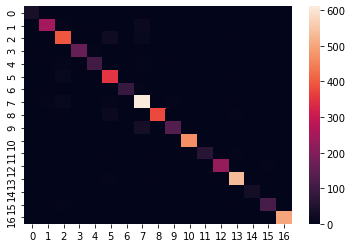

In [14]:
'''
# Step 4: Prediction with random forest
'''
y_pre = rf_rand_search.best_estimator_.predict(x_test)

C = confusion_matrix(y_test, y_pre)

seaborn.heatmap(C)